# **PEDIDOS DE REFEIÇÕES: LIGHT GBM**



### Instalação de bibliotecas

In [ ]:
# Apenas a biblioteca shap precisa ser instalada; as demais utilizadas neste notebook já vêm pré-instaladas no Google Colab
! pip install shap

### Carregamento de bibliotecas

In [ ]:
from IPython.display import display
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb                                         # Light GBM
from sklearn.model_selection import KFold, cross_validate      # Validação cruzada
from sklearn.model_selection import GridSearchCV               # Otimização de hiperparâmetros via grid search
from sklearn.model_selection import RandomizedSearchCV         # Otimização de hiperparâmetros via random search
import shap                                                    # Interpretabilidade de modelos de ML

### Leitura da base de dados

In [3]:
dados_refeicoes = pd.read_table("Pedidos_Refeicoes.txt", sep = "\t")

### Visualização da base de dados

In [4]:
display(dados_refeicoes)

,ID_RESPONDENTE,IDADE,GENERO,ESTADO_CIVIL,OCUPACAO_USUAL,RENDA_MENSAL_FAMILIAR,GRAU_EDUCACAO,REFEICAO_MAIS_FREQUENTE,COMPRAS_SAUDAVEIS,RECLAMACAO_ATRASO,AVALIACAO_MEDIA_ANTERIOR,INFLUENCIADO_POR_NOTA
0,1,29,Feminino,Casado,Sem Ocupacao,5300,Graduacao,Almoco,Sim,Sim,4.5,1
1,2,37,Masculino,Casado,Empregado CLT,28100,Pos-Graduacao,Lanches,Sim,Sim,4.5,0
2,3,36,Feminino,Casado,Empregado CLT,14000,Graduacao,Cafe da manha,Nao,Nao,4.2,1
3,4,28,Masculino,Casado,Autonomo,10900,Ensino Fund./Medio,Cafe da manha,Nao,Nao,4.5,0
4,5,31,Feminino,Casado,Estudante,8100,Graduacao,Jantar,Nao,Nao,4.7,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2739,2740,27,Masculino,Solteiro,Sem Ocupacao,3300,Sem Instrucao,Jantar,Nao,Nao,4.2,1
2740,2741,40,Masculino,Casado,Empregado CLT,3900,Graduacao,Almoco,Nao,Nao,4.6,1
2741,2742,34,Masculino,Casado,Empregado CLT,8700,Sem Instrucao,Almoco,Nao,Nao,4.7,1
2742,2743,48,Feminino,Casado,Empregado CLT,6200,Pos-Graduacao,Lanches,Sim,Nao,4.6,0


### Separação de features e target

In [5]:
X = dados_refeicoes.drop(columns = ['INFLUENCIADO_POR_NOTA', 'ID_RESPONDENTE'])
y = dados_refeicoes['INFLUENCIADO_POR_NOTA']

### Criação de colunas dummy para variáveis explicativas qualitativas

In [6]:
X = pd.get_dummies(X, drop_first = True)

### Modelo 1: Light GBM com otimização de hiperparâmetros via validação cruzada, com grid search

In [7]:
# Grid de valores dos hiperparâmetros
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'max_depth': [2, 3, 5, 10],
    'min_data_in_leaf': [10, 20, 50, 100]
}

In [8]:
# Busca da melhor combinação de hiperparâmetros, via validação cruzada com grid search, com otimização de AUC e k = 10
lightgbm = lgb.LGBMClassifier(verbose = -1, random_state = 123)
cv = KFold(n_splits = 10, shuffle = True, random_state = 123)
scoring = {'AUC': 'roc_auc', 'balanced_accuracy': 'balanced_accuracy', 'recall': 'recall'}
grid_search = GridSearchCV(lightgbm, param_grid, cv = cv, scoring = scoring, refit = 'AUC')
grid_search.fit(X, y)

GridSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
             estimator=LGBMClassifier(random_state=123, verbose=-1),
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.5],
                         'max_depth': [2, 3, 5, 10],
                         'min_data_in_leaf': [10, 20, 50, 100],
                         'n_estimators': [10, 50, 100, 200]},
             refit='AUC',
             scoring={'AUC': 'roc_auc',
                      'balanced_accuracy': 'balanced_accuracy',
                      'recall': 'recall'})

In [9]:
# Melhor configuração de hiperparâmetros identificada
print(grid_search.best_params_)

{'learning_rate': 0.05, 'max_depth': 5, 'min_data_in_leaf': 100, 'n_estimators': 50}


In [10]:
# Tabela de desempenho com todas as combinações de hiperparâmetros testadas, ordenadas do maior para o menor AUC médio nos conjuntos de teste
resultados_grid = pd.DataFrame(grid_search.cv_results_)
resultados_grid = resultados_grid[['params',
                                   'mean_test_AUC', 'std_test_AUC', 'rank_test_AUC',
                                   'mean_test_balanced_accuracy', 'std_test_balanced_accuracy', 'rank_test_balanced_accuracy',
                                   'mean_test_recall', 'std_test_recall', 'rank_test_recall']].sort_values(by = 'rank_test_AUC')
resultados_grid

,params,mean_test_AUC,std_test_AUC,rank_test_AUC,mean_test_balanced_accuracy,std_test_balanced_accuracy,rank_test_balanced_accuracy,mean_test_recall,std_test_recall,rank_test_recall
109,"{'learning_rate': 0.05, 'max_depth': 5, 'min_d...",0.788361,0.015706,1,0.700625,0.024103,7,0.897860,0.018263,143
47,"{'learning_rate': 0.01, 'max_depth': 5, 'min_d...",0.787588,0.015318,2,0.696579,0.023008,16,0.898873,0.017958,138
63,"{'learning_rate': 0.01, 'max_depth': 10, 'min_...",0.785923,0.014473,3,0.701167,0.025169,4,0.898858,0.017744,139
110,"{'learning_rate': 0.05, 'max_depth': 5, 'min_d...",0.785910,0.013760,4,0.698393,0.025564,10,0.894667,0.017400,152
125,"{'learning_rate': 0.05, 'max_depth': 10, 'min_...",0.785560,0.013140,5,0.701049,0.024264,6,0.894161,0.017000,153
...,...,...,...,...,...,...,...,...,...,...
243,"{'learning_rate': 0.5, 'max_depth': 10, 'min_d...",0.710155,0.021644,252,0.649372,0.017681,191,0.828629,0.024070,244
12,"{'learning_rate': 0.01, 'max_depth': 2, 'min_d...",0.708716,0.015390,253,0.500000,0.000000,231,1.000000,0.000000,1
8,"{'learning_rate': 0.01, 'max_depth': 2, 'min_d...",0.708716,0.015390,253,0.500000,0.000000,231,1.000000,0.000000,1
4,"{'learning_rate': 0.01, 'max_depth': 2, 'min_d...",0.708716,0.015390,253,0.500000,0.000000,231,1.000000,0.000000,1


In [11]:
# Modelo final a partir da melhor combinação de hiperparâmetros
lightgbm_1 = grid_search.best_estimator_

### Modelo 2: Light GBM com otimização de hiperparâmetros via validação cruzada, com random search

In [12]:
# Grid de valores dos hiperparâmetros
param_grid = {
    'n_estimators': np.arange(10, 201, 10),
    'learning_rate': np.arange(0.01, 0.51, 0.01),
    'max_depth': np.arange(2, 11),
    'min_data_in_leaf': np.arange(10, 101)
}

In [13]:
# Busca da melhor combinação de hiperparâmetros, via validação cruzada com random search, com otimização de AUC e k = 10
lightgbm = lgb.LGBMClassifier(verbose = -1, random_state = 123)
cv = KFold(n_splits = 10, shuffle = True, random_state = 123)
scoring = {'AUC': 'roc_auc', 'balanced_accuracy': 'balanced_accuracy', 'recall': 'recall'}
random_search = RandomizedSearchCV(lightgbm, param_grid, cv = cv, scoring = scoring, refit = 'AUC', n_iter = 50, random_state = 123)
random_search.fit(X, y)

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
                   estimator=LGBMClassifier(random_state=123, verbose=-1),
                   n_iter=50,
                   param_distributions={'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35...
        49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
        62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,
        75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,
        88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100]),
                                        'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200])},
                   random_state=123, refit='AUC',
                   scoring={'AUC': 'roc_auc',
                            'balanced_accuracy': 'balanced_accuracy',
                            'recall': 'recall'})

In [14]:
# Melhor configuração de hiperparâmetros identificada
print(random_search.best_params_)

{'n_estimators': 60, 'min_data_in_leaf': 43, 'max_depth': 5, 'learning_rate': 0.04}


In [15]:
# Tabela com todas as combinações de hiperparâmetros testadas, ordenadas do maior para o menor AUC médio nos conjuntos de teste
resultados_grid = pd.DataFrame(random_search.cv_results_)
resultados_grid = resultados_grid[['params',
                                   'mean_test_AUC', 'std_test_AUC', 'rank_test_AUC',
                                   'mean_test_balanced_accuracy', 'std_test_balanced_accuracy', 'rank_test_balanced_accuracy',
                                   'mean_test_recall', 'std_test_recall', 'rank_test_recall']].sort_values(by = 'rank_test_AUC')
resultados_grid

,params,mean_test_AUC,std_test_AUC,rank_test_AUC,mean_test_balanced_accuracy,std_test_balanced_accuracy,rank_test_balanced_accuracy,mean_test_recall,std_test_recall,rank_test_recall
45,"{'n_estimators': 60, 'min_data_in_leaf': 43, '...",0.785599,0.016228,1,0.697968,0.022242,2,0.892545,0.018070,16
8,"{'n_estimators': 40, 'min_data_in_leaf': 45, '...",0.782411,0.013491,2,0.680695,0.019078,24,0.904449,0.018592,3
2,"{'n_estimators': 110, 'min_data_in_leaf': 46, ...",0.781881,0.015663,3,0.698058,0.022800,1,0.894113,0.022613,13
24,"{'n_estimators': 10, 'min_data_in_leaf': 34, '...",0.779290,0.017893,4,0.689424,0.018873,8,0.879735,0.024783,24
13,"{'n_estimators': 40, 'min_data_in_leaf': 38, '...",0.777231,0.015708,5,0.690004,0.020962,6,0.892568,0.023747,15
37,"{'n_estimators': 20, 'min_data_in_leaf': 64, '...",0.777141,0.015715,6,0.694461,0.022017,3,0.890855,0.022723,18
41,"{'n_estimators': 50, 'min_data_in_leaf': 83, '...",0.773468,0.012004,7,0.681794,0.022673,23,0.903715,0.020116,4
39,"{'n_estimators': 10, 'min_data_in_leaf': 50, '...",0.772018,0.015735,8,0.688337,0.020281,10,0.898900,0.023158,9
30,"{'n_estimators': 70, 'min_data_in_leaf': 86, '...",0.770691,0.009847,9,0.692030,0.027662,4,0.901674,0.022142,7
44,"{'n_estimators': 30, 'min_data_in_leaf': 43, '...",0.770319,0.016106,10,0.683562,0.021844,19,0.895154,0.020201,12


In [16]:
# Modelo final a partir da melhor combinação de hiperparâmetros
lightgbm_2 = random_search.best_estimator_

### Estimativa de desempenho do modelo 1 em dados totalmente apartados, via validação cruzada aninhada

In [17]:
# Grid de valores dos hiperparâmetros
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'max_depth': [2, 3, 5, 10],
    'min_data_in_leaf': [10, 20, 50, 100]
}

In [18]:
# Validação cruzada aninhada com grid search e otimização de AUC, k1 = 3 e k2 = 5
lightgbm = lgb.LGBMClassifier(verbose = -1, random_state = 123)
inner_cv = KFold(n_splits = 3, shuffle = True, random_state = 123)
outer_cv = KFold(n_splits = 5, shuffle = True, random_state = 123)

scoring = {'AUC': 'roc_auc', 'balanced_accuracy': 'balanced_accuracy', 'recall': 'recall'}
grid_search = GridSearchCV(lightgbm, param_grid, cv = inner_cv, scoring = scoring, refit = 'AUC')
nested_scores = cross_validate(grid_search, X = X, y = y, cv = outer_cv, scoring = scoring)

In [19]:
# AUC das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_AUC'].round(3))
print("Média de AUC: " + str(round(np.mean(nested_scores['test_AUC']), 3)))
print("D.P. de AUC: " + str(round(np.std(nested_scores['test_AUC']), 3)))

[0.77  0.781 0.779 0.774 0.766]
Média de AUC: 0.774
D.P. de AUC: 0.006


In [20]:
# Acurácia balanceada das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_balanced_accuracy'].round(3))
print("Média de Acurácia Balanceada: " + str(round(np.mean(nested_scores['test_balanced_accuracy']), 3)))
print("D.P. de Acurácia Balanceada: " + str(round(np.std(nested_scores['test_balanced_accuracy']), 3)))

[0.67  0.715 0.72  0.547 0.654]
Média de Acurácia Balanceada: 0.661
D.P. de Acurácia Balanceada: 0.062


In [21]:
# Sensibilidade das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_recall'].round(3))
print("Média de Sensibilidade: " + str(round(np.mean(nested_scores['test_recall']), 3)))
print("D.P. de Sensibilidade: " + str(round(np.std(nested_scores['test_recall']), 3)))

[0.906 0.886 0.92  0.984 0.929]
Média de Sensibilidade: 0.925
D.P. de Sensibilidade: 0.033


### Estimativa de desempenho do modelo 2 em dados totalmente apartados, via validação cruzada aninhada

In [22]:
# Grid de valores dos hiperparâmetros
param_grid = {
    'n_estimators': np.arange(10, 201, 10),
    'learning_rate': np.arange(0.01, 0.51, 0.01),
    'max_depth': np.arange(2, 11),
    'min_data_in_leaf': np.arange(10, 101)
}

In [23]:
# Validação cruzada aninhada com random search e otimização de AUC, k1 = 3 e k2 = 5
lightgbm = lgb.LGBMClassifier(verbose = -1, random_state = 123)
inner_cv = KFold(n_splits = 3, shuffle = True, random_state = 123)
outer_cv = KFold(n_splits = 5, shuffle = True, random_state = 123)

scoring = {'AUC': 'roc_auc', 'balanced_accuracy': 'balanced_accuracy', 'recall': 'recall'}
random_search = RandomizedSearchCV(lightgbm, param_grid, cv = inner_cv, scoring = scoring, refit = 'AUC', n_iter = 50, random_state = 123)
nested_scores = cross_validate(random_search, X = X, y = y, cv = outer_cv, scoring = scoring)

In [24]:
# AUC das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_AUC'].round(3))
print("Média de AUC: " + str(round(np.mean(nested_scores['test_AUC']), 3)))
print("D.P. de AUC: " + str(round(np.std(nested_scores['test_AUC']), 3)))

[0.773 0.791 0.784 0.788 0.777]
Média de AUC: 0.783
D.P. de AUC: 0.007


In [25]:
# Acurácia balanceada das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_balanced_accuracy'].round(3))
print("Média de Acurácia Balanceada: " + str(round(np.mean(nested_scores['test_balanced_accuracy']), 3)))
print("D.P. de Acurácia Balanceada: " + str(round(np.std(nested_scores['test_balanced_accuracy']), 3)))

[0.674 0.715 0.717 0.701 0.669]
Média de Acurácia Balanceada: 0.695
D.P. de Acurácia Balanceada: 0.02


In [26]:
# Sensibilidade das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_recall'].round(3))
print("Média de Sensibilidade: " + str(round(np.mean(nested_scores['test_recall']), 3)))
print("D.P. de Sensibilidade: " + str(round(np.std(nested_scores['test_recall']), 3)))

[0.914 0.886 0.92  0.892 0.883]
Média de Sensibilidade: 0.899
D.P. de Sensibilidade: 0.015


### Aplicação do modelo final de Light GBM na base de dados



In [27]:
# Aplicação do modelo (cálculo das probabilidades preditas)
y_prob = lightgbm_2.predict_proba(X)[:,1]

In [28]:
# Definição de ponto de corte
ponto_corte = y.astype(int).mean()

In [29]:
# Atribuição da categoria predita
dados_refeicoes['y_pred'] = (y_prob >= ponto_corte).astype(int)

### Importância das features do modelo final

In [30]:
# Cálculo de medida de importância de Gini
importancias = lightgbm_2.feature_importances_
features = X.columns

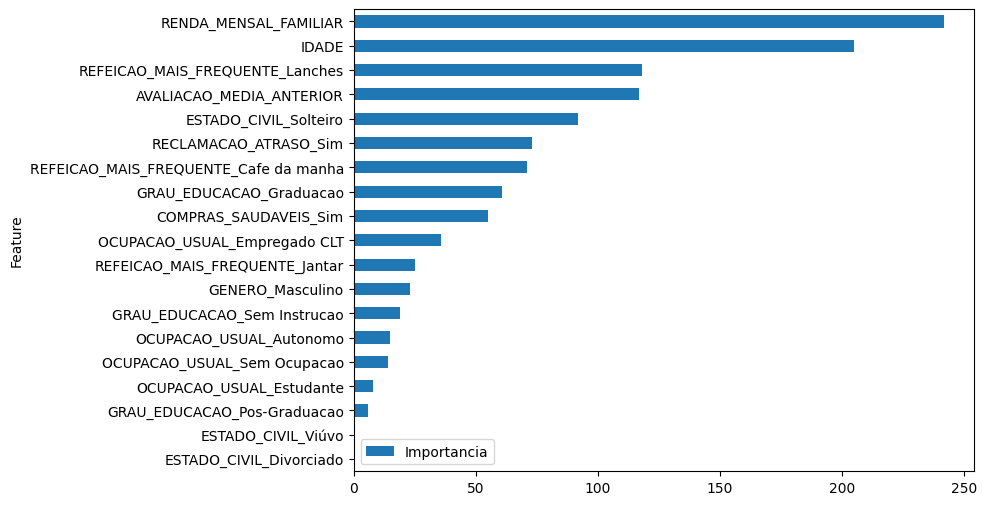

In [31]:
# Gráfico das importâncias de Gini
df_importancias = pd.DataFrame({'Feature': features, 'Importancia': importancias}).sort_values(by = 'Importancia', ascending = True)
df_importancias.plot.barh(x = 'Feature', y = 'Importancia', figsize = (8, 6))
plt.show()

In [32]:
# Cálculo de valores SHAP para as observações
explainer = shap.Explainer(lightgbm_2)
valores_shap = explainer(X)

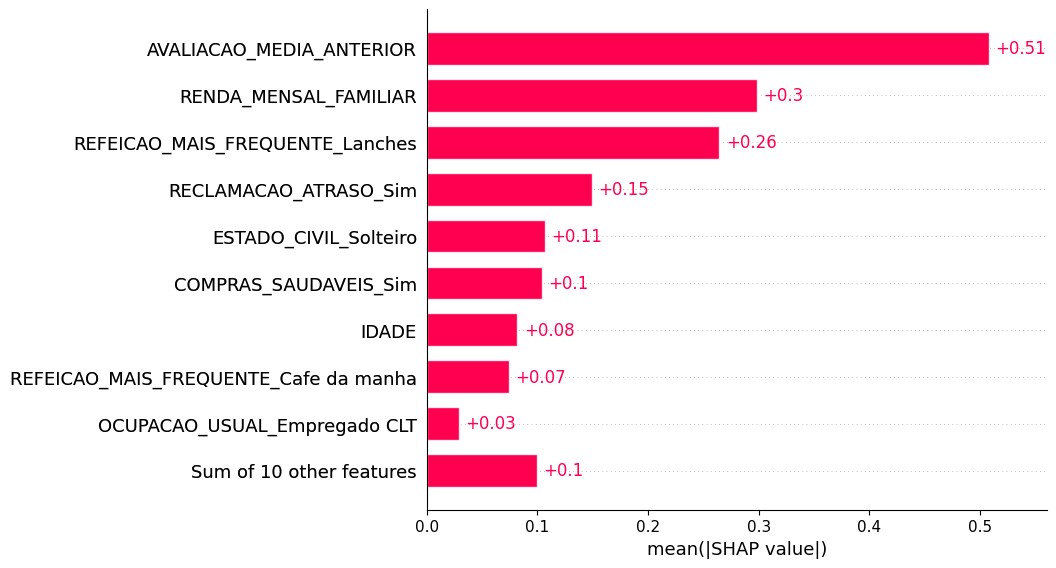

In [33]:
# Gráfico do SHAP absoluto médio por feature
shap.plots.bar(valores_shap)

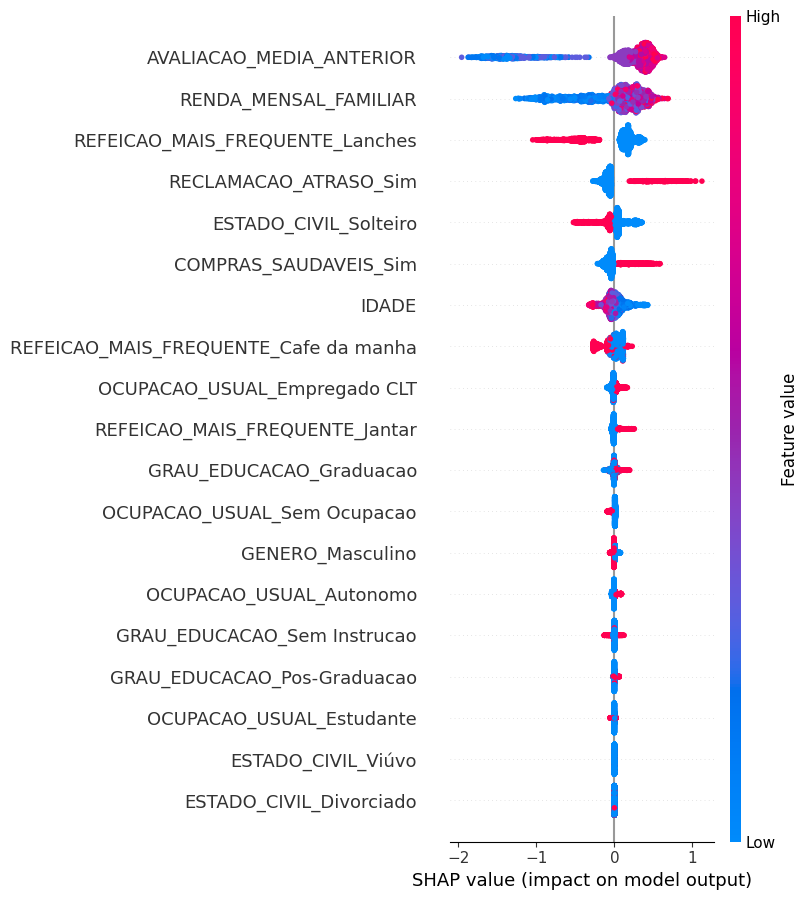

In [34]:
# Gráfico de distribuição de valores SHAP por feature: "enxame de abelhas" (beeswarm plot)
shap.summary_plot(valores_shap)